# EXERCISE 12 - The HR diagram

This assignment is about stars...

We will work with a star catalogue of 240 stars described by the following information:

- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)

We also have the following data for each star:

- Color (Red/Orange/Yellow/White/Blue)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)

This dataset has been collected by Deepraj Baidya and was originally published on Kaggle.

## IMPORT MODULES

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

## LOAD FILE

To download the data file (to do only if haven't done already):

    import urllib.request
    
    urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

In [2]:
df_stars = pd.read_csv("stars.csv")

df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


# L15:

## Tasks

We find the same organization of stars in this 2D plane. Main Sequence stars and White Dwarves are fairly easy to isolate from the rest: a statistical model should be able to easily classify them. Based only on Luminosity and Temperature, Dwarf stars and Giant stars have higher intra-group variability: Supergiant and Hypergiant cover the same space (same for Brown and Red Dwarves). Additionnal variables might be needed to correctly identify the types of those stars.

- Apply PCA to the dataset at your disposal (hint: don't use columns with labels, only those with real numbers).
- Project the dataset into the principal components, and do a scatter plot of the first two.
- This will look terrible. Think about the units!
- Explore what happens if you rescale the data first.

This is actually a very important lesson in machine learning: Massaging your data before giving them to an algorithm can make things much much better.

- You can try an linear, affine transformation such that each dimension goes between -1 and 1.
- Or (which is the usual machine-learning approach) standardize your data such that each dimension has mean=0 and variance=1.
- Redo your PCA. Should be much much better.
- How much variance is explained by those two components?

# 1 - DATA EXPLORATION

In [3]:
le = LabelEncoder()

# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])

labels = le.inverse_transform(df_stars['Star type']) # star type of each object
class_names = le.classes_ # star types considered

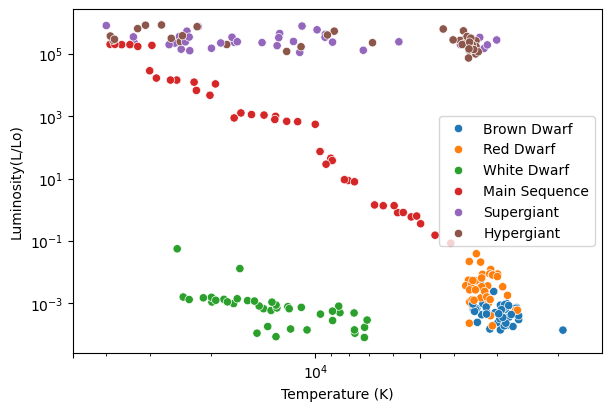

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), layout='constrained')

sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([5000, 10000, 50000])
ax.set_xlim(5e4, 1.5e3)

plt.show()

## Clustering

Let's see what the clustering algorithms do without PCA.

In [5]:
# Data set-up

column = ['Temperature (K)', 'Luminosity(L/Lo)']
X = df_stars[column].copy()
X = np.log10(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

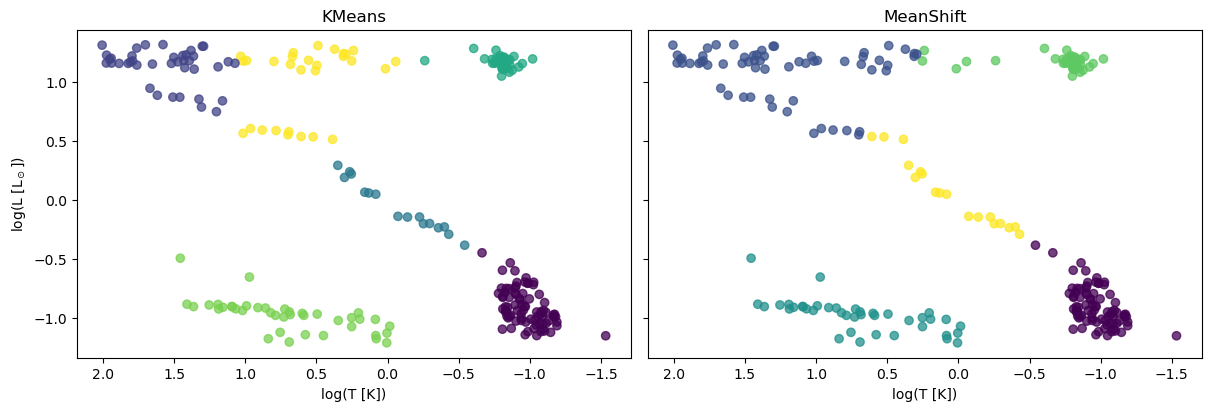

In [6]:
cl, bw = 6, .9 # chosen after trial and error

fig, (ax, bx) = plt.subplots(1, 2, figsize=(12, 4), sharey=True, layout='constrained')

# KMeans

km = KMeans(n_clusters=cl, n_init='auto')
km.fit(X_scaled)
Y = km.predict(X_scaled)

ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=Y, cmap='viridis', alpha=.75)
ax.xaxis.set_inverted(True)

ax.set_title('KMeans')
ax.set_xlabel('log(T [K])')
ax.set_ylabel(r'log(L [L$_\odot$])')

# MeanShift

ms = MeanShift(bandwidth=bw, bin_seeding=True, cluster_all=False)
ms.fit(X_scaled)
Y = ms.predict(X_scaled)

bx.scatter(X_scaled[:, 0], X_scaled[:, 1], c=Y, cmap='viridis', alpha=.75)
bx.xaxis.set_inverted(True)

bx.set_title('MeanShift')
bx.set_xlabel('log(T [K])');

# 2 - PCA (no rescaling)

In [7]:
# Data set-up

column = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
X = df_stars[column].copy()
X[column[0:3]] = np.log10(X[column[0:3]])

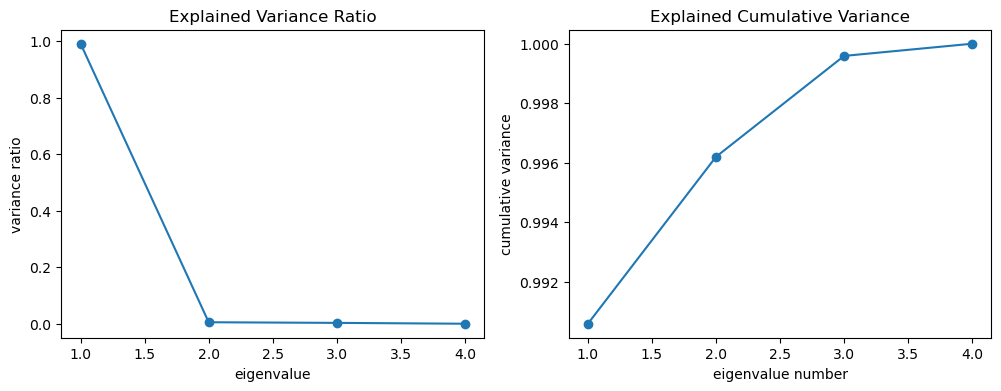

In [8]:
## --- EXPLAINED VARIANCE --- ##

n_comp = len(column)

pca = PCA(n_components=n_comp)
pca.fit(X)

evals = pca.explained_variance_ratio_

fig, (ax, bx) = plt.subplots(1, 2, figsize=(12, 4))

ax.plot(np.arange(n_comp) + 1, evals)
ax.scatter(np.arange(n_comp) + 1, evals)

ax.set_title('Explained Variance Ratio')
ax.set_xlabel("eigenvalue")
ax.set_ylabel("variance ratio")

bx.plot(np.arange(n_comp) + 1, evals.cumsum())
bx.scatter(np.arange(n_comp) + 1, evals.cumsum())

bx.set_title('Explained Cumulative Variance')
bx.set_xlabel("eigenvalue number")
bx.set_ylabel("cumulative variance");

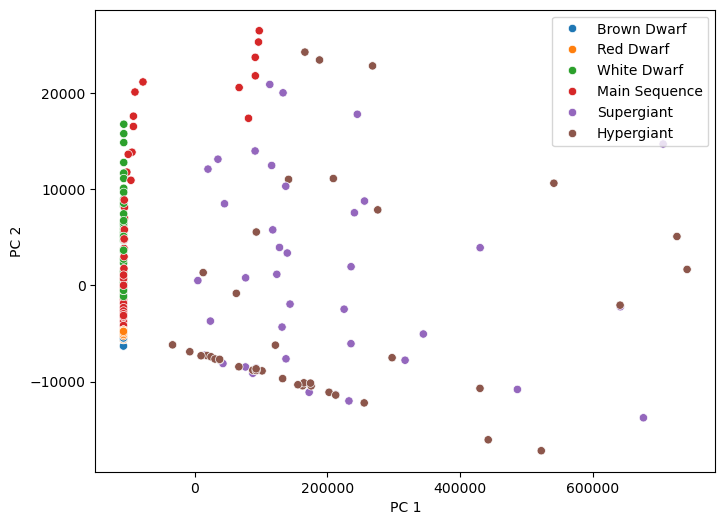

In [9]:
pca = PCA(n_components=2)
x = pca.fit_transform(df_stars[column])

comp = pca.components_

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2');

# 3 - PCA (with rescaling)

In [10]:
# Rescale data

column = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
X = df_stars[column].copy()
X[column[0:3]] = np.log10(X[column[0:3]])

scaler = StandardScaler() # MinMaxScaler((-1, 1))
X_scaled = scaler.fit_transform(X)

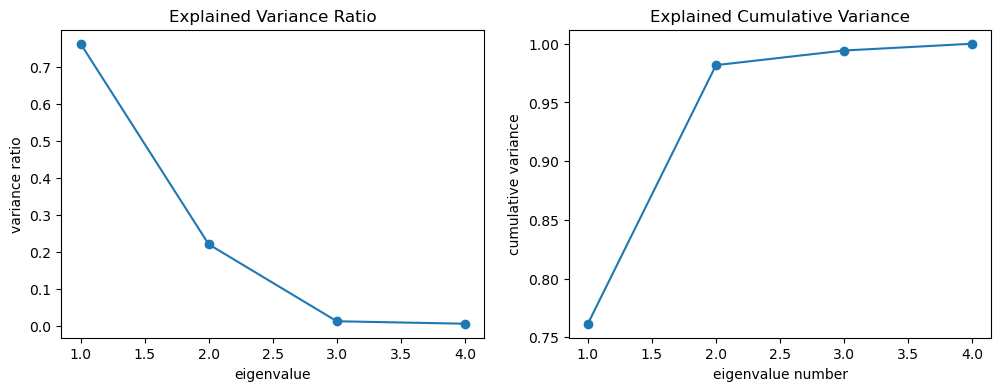

In [11]:
## --- EXPLAINED VARIANCE --- ##

n_comp = len(column)

pca = PCA(n_components=n_comp)
pca.fit(X_scaled)

evals = pca.explained_variance_ratio_

fig, (ax, bx) = plt.subplots(1, 2, figsize=(12, 4))

ax.plot(np.arange(n_comp) + 1, evals)
ax.scatter(np.arange(n_comp) + 1, evals)

ax.set_title('Explained Variance Ratio')
ax.set_xlabel("eigenvalue")
ax.set_ylabel("variance ratio")

bx.plot(np.arange(n_comp) + 1, evals.cumsum())
bx.scatter(np.arange(n_comp) + 1, evals.cumsum())

bx.set_title('Explained Cumulative Variance')
bx.set_xlabel("eigenvalue number")
bx.set_ylabel("cumulative variance");

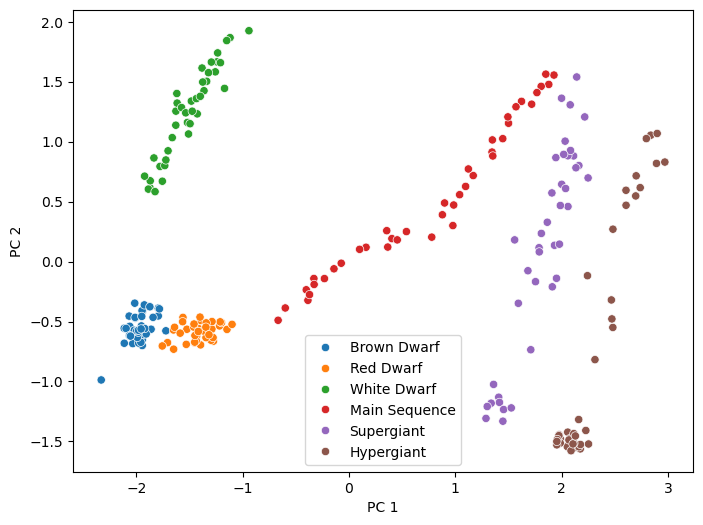

In [12]:
pca = PCA(n_components=2)
x = pca.fit_transform(X_scaled)

comp = pca.components_

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2');

## Clustering

In [13]:
# Bandwidth estimation for MeanShift

bandwidth = estimate_bandwidth(x)
print(f'Estimated bandwidth: {bandwidth:.2f}')

Estimated bandwidth: 1.46


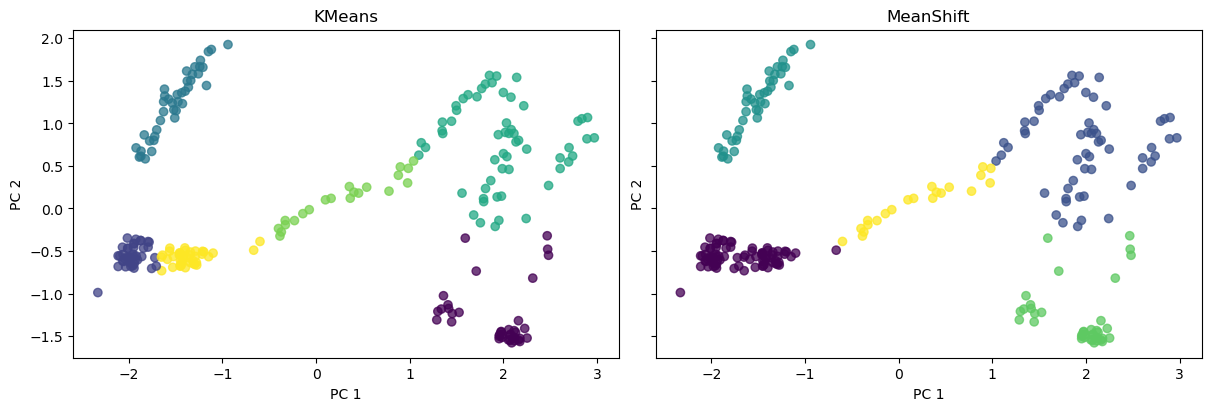

In [18]:
cl, bw = 6, .9 #bandwidth

fig, (ax, bx) = plt.subplots(1, 2, figsize=(12, 4), sharey=True, layout='constrained')

# KMeans

km = KMeans(n_clusters=cl, n_init='auto')
Y = km.fit_predict(x)

ax.scatter(x[:, 0], x[:, 1], c=Y, cmap='viridis', alpha=.75)

ax.set_title('KMeans')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

# MeanShift

ms = MeanShift(bandwidth=bw, bin_seeding=True, cluster_all=False)
ms.fit(X_scaled)
Y = ms.predict(X_scaled)

bx.scatter(x[:, 0], x[:, 1], c=Y, cmap='viridis', alpha=.75)

bx.set_title('MeanShift')
bx.set_xlabel('PC 1')
bx.set_ylabel('PC 2');